In [16]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [17]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# Human-in-the-Loop

In [18]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

## Agent 설계

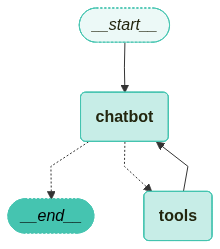

In [20]:
########## 1. State ##########
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]


########## 2. TOOLS ##########
# 도구 초기화
news_tool = GoogleNews()

# 키워드 뉴스 검색 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    # news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]


# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM + 도구 
llm_with_tools = llm.bind_tools(tools)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional Edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


########## 4. EDGE ##########
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


########## 5. MEMORY ##########
memory = MemorySaver()


########## 6. COMPILE  ##########
graph = graph_builder.compile(checkpointer=memory)


########## 7. VISUALIZE ##########
visualize_graph(graph)

## 도구 호출 흐름 이해

In [21]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

In [22]:
question = "AI 관련 최신 뉴스를 알려주세요."

input = State(messages=[("user", question)])
config = RunnableConfig(
    recursion_limit=10,  
    configurable={"thread_id": "001"},  
    tags=["MY-TAG"], 
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        print(f"\n[{key}]\n")

        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_PqtD9ZAYPs56KCpI8Oe3t5Zf)
 Call ID: call_PqtD9ZAYPs56KCpI8Oe3t5Zf
  Args:
    query: AI


In [23]:
# 그래프게 제대로 작동하고 있는지 확인 
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

snapshot.next 통해 다음 도구가 무엇인지 확인했고, 실제로도 그러한지 확인 

In [24]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_PqtD9ZAYPs56KCpI8Oe3t5Zf"
        type: "tool_call"


[출력 내용]

- 중단된 단계의 type은 "tool_call" : 도구 실행
    - LLM이 도구 실행 요청 -> tool_call 메시지 생성 
    - 하지만 도구 실행 결과(tool_message)는 존재하지 않음 : 도구 실행 결과 없음 
- 도구 실행 전 단계에서 그래프 실행 중단 

In [25]:
# 그래프 스트리밍 
# input : `None`는 현재 상태에 아무것도 추가하지 않음. 기존에 저장된 thread_id 상태 기반으로 이어서 실행 
# config : 실행 설정 정보 (RunnableConfig)
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_PqtD9ZAYPs56KCpI8Oe3t5Zf)
 Call ID: call_PqtD9ZAYPs56KCpI8Oe3t5Zf
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE15TmFGRGprVTZ4a3NlNTh1UkN1V3VqeEpyRVdza0ZBdGJNUDVYSUVySHZVUlN6eS1EaDczZ1FHQ29OOXZ2LXhMM2x2aWxUdnlwamQ2ZFJ3?oc=5", "content": "\"GPU 256장, 누가 거머쥘까\"…정부 '특화 AI' 사업 디데이, 흥행 성공할까 - 지디넷코리아"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTFBrMzRTMF9FSnUxR3FNbThJenhLa1FWeHJzdlpES0NySC13V1ZVdTVwTm41ZURqTVRUOVh5Q21jTDBHR3JLN3FDWkFfdGV4dw?oc=5", "content": "네이버, 내년 상반기 AI탭 출격…AI 패권 경쟁 맞대응 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE4xVDAzVVNEX0wtc3NmYkJ4V2E3SnVJeWJ5LTdheHNWWGZZSUR3TVlpMTI5VWZDLUR2a2N1S1ZOUGdFVU9ndjBVYzR5RHBqell2UVZ0c2YxSnhPMDQ?oc=5", "content": "美 캘리포니아주, 아동·청소년 대상 AI챗봇 규제 최초 입법 

## 중단 지점에서 상태 저장 및 재실행 제어 

- 챗봇에 인간이 개입할 수 있는 실행을 추가하여 필요할 때 인간의 감독과 개입을 가능하게 함 
- **checkpointer**를 추가했기 때문에, 그래프는 **무기한** 일시 중지되고 언제든지 다시 시작할 수 있음
- 아래는 `get_state_history` 메서드를 사용하여 상태 기록을 가져오는 방법 (역순으로 추적)

In [27]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


In [28]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '001', 'checkpoint_ns': '', 'checkpoint_id': '1f0a8890-837b-6fc0-8002-c17cd741ad44'}}


In [29]:
to_replay.config

{'configurable': {'thread_id': '001',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a8890-837b-6fc0-8002-c17cd741ad44'}}

In [30]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE15TmFGRGprVTZ4a3NlNTh1UkN1V3VqeEpyRVdza0ZBdGJNUDVYSUVySHZVUlN6eS1EaDczZ1FHQ29OOXZ2LXhMM2x2aWxUdnlwamQ2ZFJ3?oc=5", "content": "\"GPU 256장, 누가 거머쥘까\"…정부 '특화 AI' 사업 디데이, 흥행 성공할까 - 지디넷코리아"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTFBrMzRTMF9FSnUxR3FNbThJenhLa1FWeHJzdlpES0NySC13V1ZVdTVwTm41ZURqTVRUOVh5Q21jTDBHR3JLN3FDWkFfdGV4dw?oc=5", "content": "네이버, 내년 상반기 AI탭 출격…AI 패권 경쟁 맞대응 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE4xVDAzVVNEX0wtc3NmYkJ4V2E3SnVJeWJ5LTdheHNWWGZZSUR3TVlpMTI5VWZDLUR2a2N1S1ZOUGdFVU9ndjBVYzR5RHBqell2UVZ0c2YxSnhPMDQ?oc=5", "content": "美 캘리포니아주, 아동·청소년 대상 AI챗봇 규제 최초 입법 - 연합뉴스"}, {"url": "https://news.google.com/rss/articles/CBMiT0FVX3lxTE9PRFBESlBnVkIzcEdFcjA5bzcySHIxZ21aMHU0dWx5MjlSa0dIVFY3bDBGNmpWRWt1NVdoNGZmUTktcUFLcV9iN201alhDeGM?oc=5", "content": "미국 캘리포니아주, 아동·청소년

-----
** End of Documents **